In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, root_mean_squared_error, r2_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVR
import xgboost as xg 

## Load data

In [120]:
df = pd.read_csv('data/anime_df_preprocessed.csv', index_col=0)
df.head()

,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,scaled_episodes,scaled_members,scaled_views_without_review,scaled_rating_counts
0,9.37,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0.000000,0.197867,0.046539,0.057268
1,9.26,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0.034673,0.782769,0.602268,0.627991
2,9.25,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0.027518,0.112683,0.038717,0.034682
3,9.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.012658,0.664323,0.416895,0.501096
4,9.16,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0.027518,0.149180,0.109112,0.090986


In [121]:
X = df.drop('rating', axis=1)
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [122]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8933, 53), (2978, 53), (8933,), (2978,))

In [123]:
regressionResult = {}

## Linear Regression

In [124]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)

In [125]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['LinearRegression'] = {"rmse": rmse, "r2": r2}
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Root Mean Squared Error: 0.8019
Test Set R-squared: 0.3816


## Ridge Regression

In [126]:
ridgeRegression = RidgeCV()
ridgeRegression.fit(X_train, y_train)
y_pred = ridgeRegression.predict(X_test)

In [127]:
print(f"Best alpha: {ridgeRegression.alpha_}")

Best alpha: 0.1


In [128]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['RidgeCV'] = {"rmse": rmse, "r2": r2}
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Root Mean Squared Error: 0.8018
Test Set R-squared: 0.3817


## GradientBoostingRegressor

In [129]:
gbRegressor = GradientBoostingRegressor()
gbRegressor.fit(X_train, y_train)
y_pred = gbRegressor.predict(X_test)

In [130]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['GradientBoostingRegressor'] = {"rmse": rmse, "r2": r2}
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Root Mean Squared Error: 0.5645
Test Set R-squared: 0.6936


## RandomForestRegressor

In [131]:
rfRegressor = RandomForestRegressor()
rfRegressor.fit(X_train, y_train)
y_pred = rfRegressor.predict(X_test)

In [132]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['RandomForestRegressor'] = {"rmse": rmse, "r2": r2}
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Root Mean Squared Error: 0.5445
Test Set R-squared: 0.7149


## XGB

In [133]:
xgbRegressor = xg.XGBRegressor()
xgbRegressor.fit(X_train, y_train)
y_pred = xgbRegressor.predict(X_test)

In [134]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['XGBRegressor'] = {"rmse": rmse, "r2": r2}
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Root Mean Squared Error: 0.5383
Test Set R-squared: 0.7213


## KNN

In [135]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [136]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['KNeighborsRegressor'] = {"rmse": rmse, "r2": r2}
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Root Mean Squared Error: 0.7243
Test Set R-squared: 0.4955


## Results

In [137]:
result_df = pd.DataFrame(regressionResult).T
result_df.to_csv('data/model_results.csv', sep=',')
result_df

,rmse,r2
LinearRegression,0.801880,0.381598
RidgeCV,0.801809,0.381708
GradientBoostingRegressor,0.564474,0.693564
RandomForestRegressor,0.544481,0.714887
XGBRegressor,0.538321,0.721302
KNeighborsRegressor,0.724279,0.495497


XGBoostingRegressor seems to be the best modale with leaset RMSE and best R2 scores

## Optimization for XGBoosting

In [138]:
param_distributions = {
    'n_estimators': stats.randint(150, 1000),
    'learning_rate': stats.uniform(0.01, 0.59),
    'subsample': stats.uniform(0.3, 0.6),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'colsample_bytree': stats.uniform(0.5, 0.4),
    'min_child_weight': [1, 2, 3, 4]
}

In [139]:
xgbRegressor = xg.XGBRegressor()
random_search = RandomizedSearchCV(estimator=xgbRegressor, param_distributions=param_distributions, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_

In [140]:
print(f"Best hyperparameters: {random_search.best_params_}")

Best hyperparameters: {'colsample_bytree': 0.5074746861401933, 'learning_rate': 0.1186266341570227, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 427, 'subsample': 0.4769478684616743}


In [141]:
y_pred = best_xgb.predict(X_test)

In [142]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test Set Root Mean Squared Error: {rmse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Root Mean Squared Error: 0.5309
Test Set R-squared: 0.7289


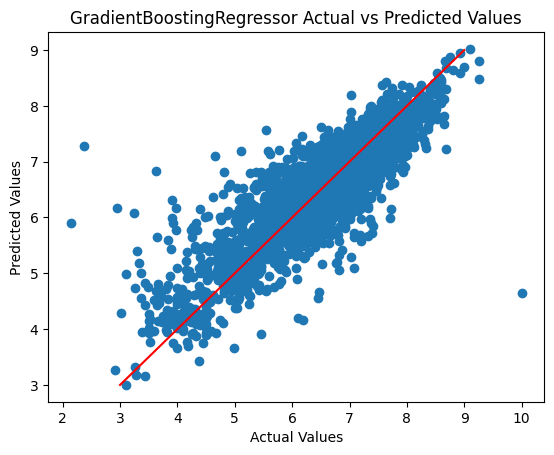

In [143]:
plt.scatter(y_test, y_pred)
plt.plot([x for x in range(3,10)],[x for x in range(3,10)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('GradientBoostingRegressor Actual vs Predicted Values')
plt.show()

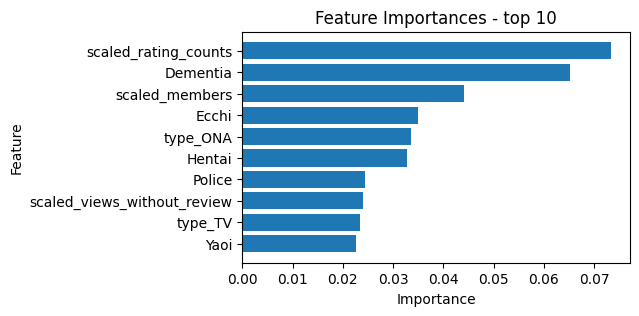

In [144]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_xgb.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(5, 3))
plt.barh(feature_importances['Feature'].head(10), feature_importances['Importance'].head(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - top 10')
plt.gca().invert_yaxis()
plt.show()

# Exploration WIP

## Classification Exploration

### Bin ratings into low, mid, and high

In [319]:
# Define bins and labels
bins = [0, 5, 8, 10]  # Define bin edges
labels = ['low', 'mid', 'high']  # Define bin labels

# Bin the data
df['binned_rating'] = pd.cut(df['rating'], bins=bins, labels=labels, include_lowest=True)

In [321]:
df.head()

,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Yuri,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,scaled_episodes,scaled_members,binned_rating
0,9.37,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0.000000,0.197867,high
1,9.26,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0.034673,0.782769,high
2,9.25,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0.027518,0.112683,high
3,9.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.012658,0.664323,high
4,9.16,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0.027518,0.149180,high


<Axes: >

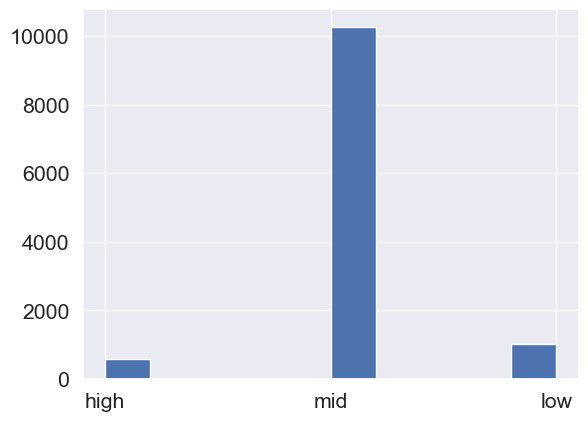

In [369]:
df['binned_rating'].hist()

### Under sampling

In [346]:
X = df.drop(columns=['rating','binned_rating'])
y = df['binned_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [351]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

<Axes: >

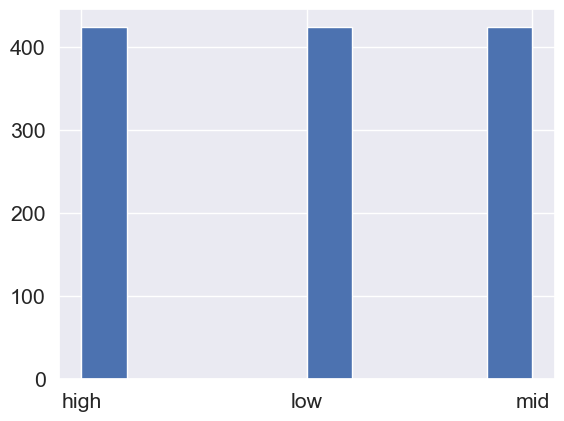

In [354]:
y_train_resampled.hist()

## GradientBoostingClassifier

In [356]:
gbClassifier = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 1.0],
    'max_depth': [3, 5, 7, 9],
}
randomSearch = RandomizedSearchCV(estimator=gbClassifier, param_distributions=param_grid, cv=5, n_jobs=-1)
randomSearch.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 1.0],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 300, 500]})

In [357]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}


In [358]:
best_gb = randomSearch.best_estimator_
y_pred = best_gb.predict(X_test)

In [359]:
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
cm = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

        high       0.23      0.83      0.36       153
         low       0.27      0.83      0.41       245
         mid       0.97      0.63      0.76      2570

    accuracy                           0.65      2968
   macro avg       0.49      0.76      0.51      2968
weighted avg       0.87      0.65      0.71      2968



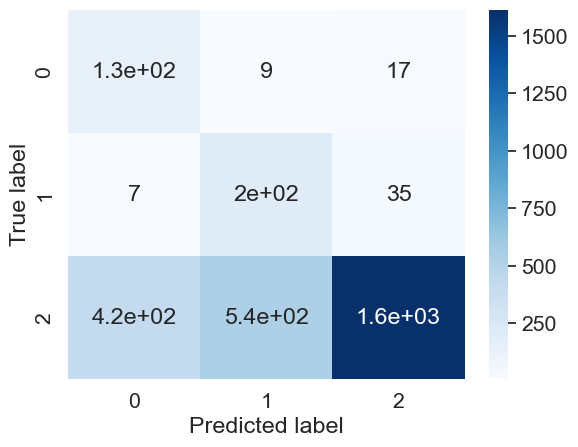

In [361]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## BalancedRandomForestClassifier

In [362]:
rfClassifier = RandomForestClassifier()

param_grid= {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

randomSearch = RandomizedSearchCV(estimator=rfClassifier, param_distributions=param_grid, cv=5, n_jobs=-1)
randomSearch.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'n_estimators': [100, 300, 500]})

In [363]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'bootstrap': False}


In [364]:
best_rf = randomSearch.best_estimator_
y_pred = best_rf.predict(X_test)

In [365]:
print(rfClassifier.class_weight)

None


In [366]:
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
cm = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

        high       0.24      0.87      0.37       153
         low       0.25      0.84      0.39       245
         mid       0.97      0.60      0.74      2570

    accuracy                           0.63      2968
   macro avg       0.49      0.77      0.50      2968
weighted avg       0.87      0.63      0.69      2968



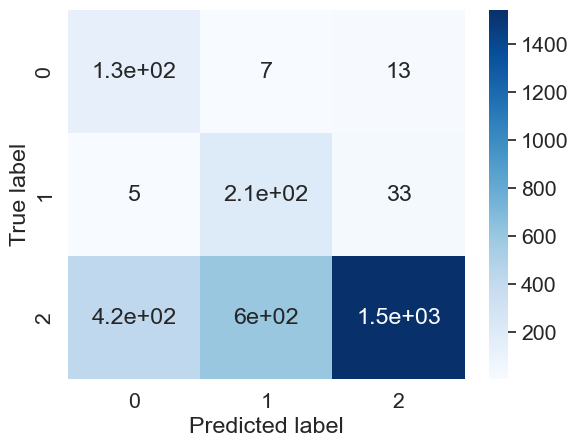

In [368]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()